# Required Modules

In [18]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import learning_curve, validation_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Standerdization

In [2]:
def stand(tr, te):
    mean = tr.mean()
    stdev = tr.std()
    n_tr = (tr-mean)/stdev
    n_te = (te-mean)/stdev
    return n_tr, n_te

# Data import 

In [3]:
train = pd.read_excel("Train(fu).xlsx", index_col=0)
test = pd.read_excel("Test(fu).xlsx", index_col=0)
train, test = stand(train, test)
x_tr = train.iloc[:,:-1]
x_te = test.iloc[:,:-1]
y_tr = train.iloc[:,-1]
y_te = test.iloc[:,-1]
print(x_tr.shape, "\n", x_te.shape, "\n", y_tr.shape, "\n", y_te.shape)

(1088, 12) 
 (362, 12) 
 (1088,) 
 (362,)


# Optimization

In [4]:
regressor = SVR()
parameters = { 'C':[1.0,5.0,10.0,15.0,25.0], 
              'degree':[3,4,5], 
              'gamma': ["auto","scale"]
               }
GS = GridSearchCV(estimator = regressor,
                  param_grid = parameters,
                  scoring ='neg_mean_squared_error',
                  cv = 5,
                  verbose = 4)
GS.fit(x_tr,y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ......C=1.0, degree=3, gamma=auto;, score=-0.342 total time=   0.0s
[CV 2/5] END ......C=1.0, degree=3, gamma=auto;, score=-0.304 total time=   0.0s
[CV 3/5] END ......C=1.0, degree=3, gamma=auto;, score=-0.390 total time=   0.0s
[CV 4/5] END ......C=1.0, degree=3, gamma=auto;, score=-0.326 total time=   0.0s
[CV 5/5] END ......C=1.0, degree=3, gamma=auto;, score=-0.250 total time=   0.0s
[CV 1/5] END .....C=1.0, degree=3, gamma=scale;, score=-0.342 total time=   0.0s
[CV 2/5] END .....C=1.0, degree=3, gamma=scale;, score=-0.304 total time=   0.0s
[CV 3/5] END .....C=1.0, degree=3, gamma=scale;, score=-0.390 total time=   0.0s
[CV 4/5] END .....C=1.0, degree=3, gamma=scale;, score=-0.328 total time=   0.0s
[CV 5/5] END .....C=1.0, degree=3, gamma=scale;, score=-0.251 total time=   0.0s
[CV 1/5] END ......C=1.0, degree=4, gamma=auto;, score=-0.342 total time=   0.0s
[CV 2/5] END ......C=1.0, degree=4, gamma=auto;

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1.0, 5.0, 10.0, 15.0, 25.0], 'degree': [3, 4, 5],
                         'gamma': ['auto', 'scale']},
             scoring='neg_mean_squared_error', verbose=4)

In [5]:
estimator_gs = GS.best_params_
print(estimator_gs)

{'C': 1.0, 'degree': 3, 'gamma': 'auto'}


# Model development

In [6]:
reg=SVR(C=1.0, gamma="auto", degree=3).fit(x_tr, y_tr)
ytr_pred = reg.predict(x_tr)
yte_pred = reg.predict(x_te)

# Metrics

In [7]:
def metrics(obs_tr, pred_tr, obs_te, pred_te):
    r2 = round(r2_score(obs_tr, pred_tr),3)
    mae_tr = round(mean_absolute_error(obs_tr, pred_tr),3)
    q2f2 = round(r2_score(obs_te, pred_te),3)
    q2f1 = round(1-(sum((obs_te - pred_te)**2)/sum((obs_te - np.mean(obs_tr))**2)),3)
    mae_te = round(mean_absolute_error(obs_te, pred_te),3)
    rmsec = round(np.sqrt(mean_squared_error(obs_tr, pred_tr)),3)
    rmsep = round(np.sqrt(mean_squared_error(obs_te, pred_te)),3)
    print("R2:", r2)
    print("MAE_TR:", mae_tr)
    print("Q2F2:", q2f2)
    print("Q2F1:", q2f1)
    print("MAE_TE:", mae_te)
    print("RMSE_tr:", rmsec)
    print("RMSE_te:", rmsep)

In [8]:
metrics(y_tr, ytr_pred, y_te, yte_pred)

R2: 0.752
MAE_TR: 0.318
Q2F2: 0.75
Q2F1: 0.75
MAE_TE: 0.336
RMSE_tr: 0.497
RMSE_te: 0.498


# Cross-Validation

In [9]:
cv = ShuffleSplit(n_splits=1000, test_size=0.3, random_state = 0)
scores = cross_validate(reg,  x_tr, y_tr, cv=cv, scoring=['neg_mean_absolute_error', 'r2'], n_jobs=-1)
output = pd.DataFrame(scores).abs()
output= output.iloc[:, 2:4]

In [10]:
cv_mean = round(output.mean(), 2)
cv_sem = round(output.std()/np.sqrt(len(output)), 3)
score = ["MAE±SEM", "R2±SEM"]
for i,j,k in zip(cv_mean, cv_sem, score):
    print(str(k)+": ", str(i)+" ± ", str(j))

MAE±SEM:  0.38 ±  0.001
R2±SEM:  0.68 ±  0.001


# Scatter Plot

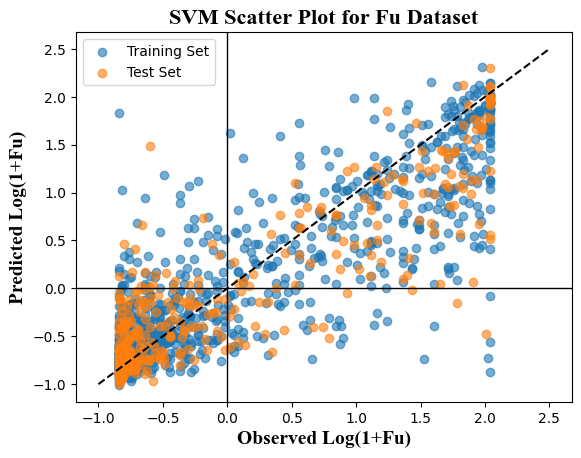

In [11]:
plt.scatter(y_tr, ytr_pred, label="Training Set", alpha=0.6)
plt.scatter(y_te, yte_pred, label="Test Set", alpha=0.6)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.title("SVM Scatter Plot for Fu Dataset", font="Times New Roman", fontsize=16, fontweight="bold")
plt.xlabel("Observed Log(1+Fu)", font="Times New Roman", fontsize=14, fontweight="bold")
plt.ylabel("Predicted Log(1+Fu)", font="Times New Roman", fontsize=14, fontweight="bold")
plt.legend()
plt.plot([-1,0,2.5], [-1,0,2.5], color='black', linestyle='--')
plt.show()

# Residual plot

In [12]:
tr_res = pd.DataFrame({
    "Residual": y_tr-ytr_pred,
    "Set":"Train"
})
te_res = pd.DataFrame({
    "Residual": y_te-yte_pred,
    "Set":"Test"
})
Res=pd.concat([tr_res, te_res], axis=0)

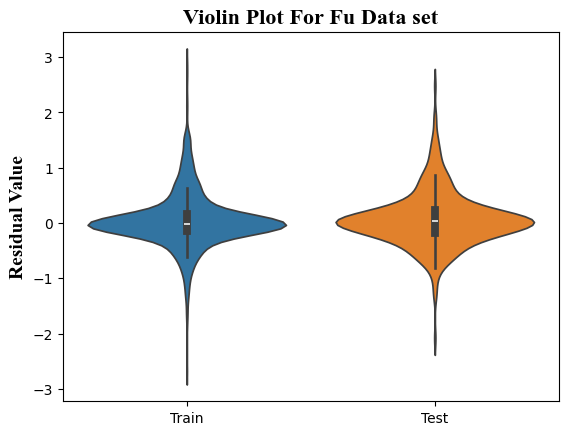

In [13]:
sns.violinplot(Res,y="Residual", x="Set", hue="Set")
plt.title('Violin Plot For Fu Data set', font="Times New Roman", fontsize=16, fontweight="bold")
plt.xlabel("")
plt.ylabel("Residual Value", font="Times New Roman", fontsize=14, fontweight="bold")
plt.show()

# Learning curve

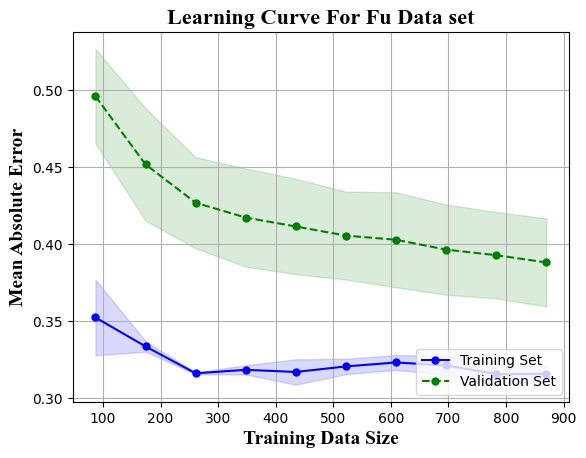

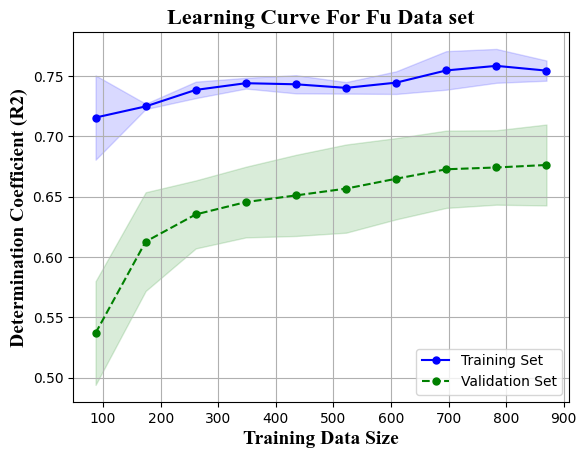

In [14]:
scores = ['neg_mean_absolute_error', 'r2']
ylabel = ['Mean Absolute Error', 'Determination Coefficient (R2)']
for i,j in zip(scores, ylabel):
    train_sizes, train_score, test_score = learning_curve(reg, x_tr, y_tr, cv=5, train_sizes=np.linspace(0.1, 1.0,10),
                                                        n_jobs=1, scoring=i)
    #calculate train and test mean
    train_mean = np.abs(np.mean(train_score, axis=1))
    train_std = np.std(train_score, axis=1)
    test_mean = np.abs(np.mean(test_score, axis=1))
    test_std = np.std(test_score, axis=1)
    
    #graph plotting
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Set')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, linestyle='--', label='Validation Set')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve For Fu Data set', font="Times New Roman", fontsize=16, fontweight="bold")
    plt.xlabel('Training Data Size', font="Times New Roman", fontsize=14, fontweight="bold")
    plt.ylabel(j, font="Times New Roman", fontsize=14, fontweight="bold")
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

# Validation curve

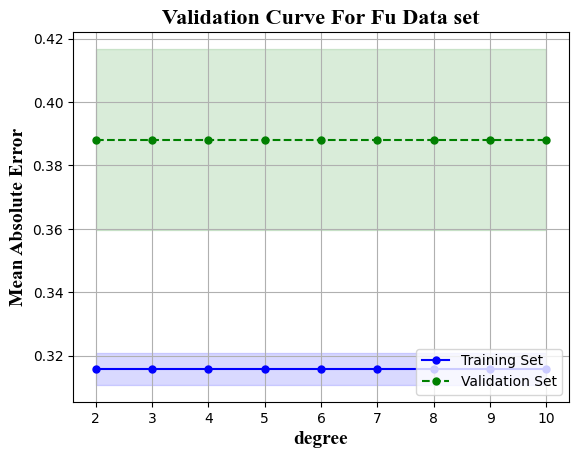

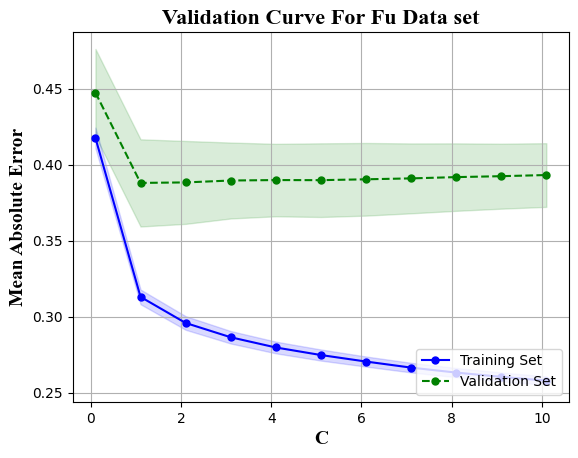

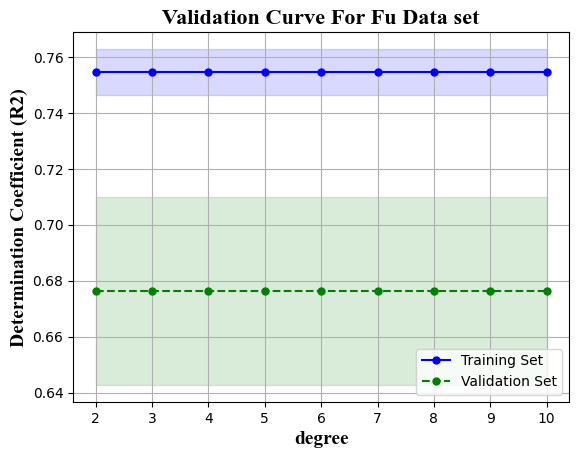

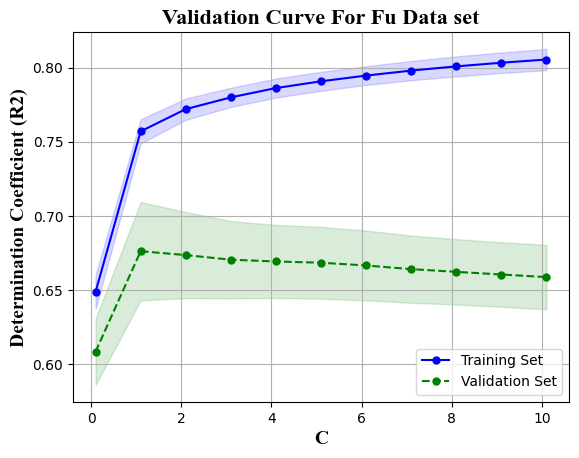

In [16]:
param = ['degree', 'C']
for i,j in zip(scores, ylabel): 
    for k in param:
        if k=='degree':
            parameters=np.arange(2,11,1)
        if k =='C':
            parameters=np.arange(0.1,11.0,1)
        train_sc, val_sc = validation_curve(reg, x_tr, y_tr, param_name=k, param_range=parameters, cv=5, scoring=i)
        # Calculating mean and standard deviation of training score
        mean_train_score = np.abs(np.mean(train_sc, axis=1))
        std_train_score = np.std(train_sc, axis=1)
         
        # Calculating mean and standard deviation of testing score
        mean_test_score = np.abs(np.mean(val_sc, axis=1))
        std_test_score = np.std(val_sc, axis=1)
        
        #graph plotting
        plt.plot(parameters, mean_train_score, color='blue', marker='o', markersize=5, label='Training Set')
        plt.fill_between(parameters, mean_train_score + std_train_score, mean_train_score - std_train_score, alpha=0.15, color='blue')
        plt.plot(parameters, mean_test_score, color='green', marker='o', markersize=5, linestyle='--', label='Validation Set')
        plt.fill_between(parameters, mean_test_score + std_test_score, mean_test_score - std_test_score, alpha=0.15, color='green')
        plt.title('Validation Curve For Fu Data set', font="Times New Roman", fontsize=16, fontweight="bold")
        plt.xlabel(k, font="Times New Roman", fontsize=14, fontweight="bold")
        plt.ylabel(j, font="Times New Roman", fontsize=14, fontweight="bold")
        plt.grid()
        plt.legend(loc='lower right')
        plt.show()

# SHAP plot

In [19]:
shap.initjs()
X_tr100 = shap.utils.sample(x_tr, 100)
explainer = shap.Explainer(reg.predict, X_tr100)
shap_an = explainer(x_tr)

PermutationExplainer explainer: 1089it [1:01:38,  3.41s/it]                                                            


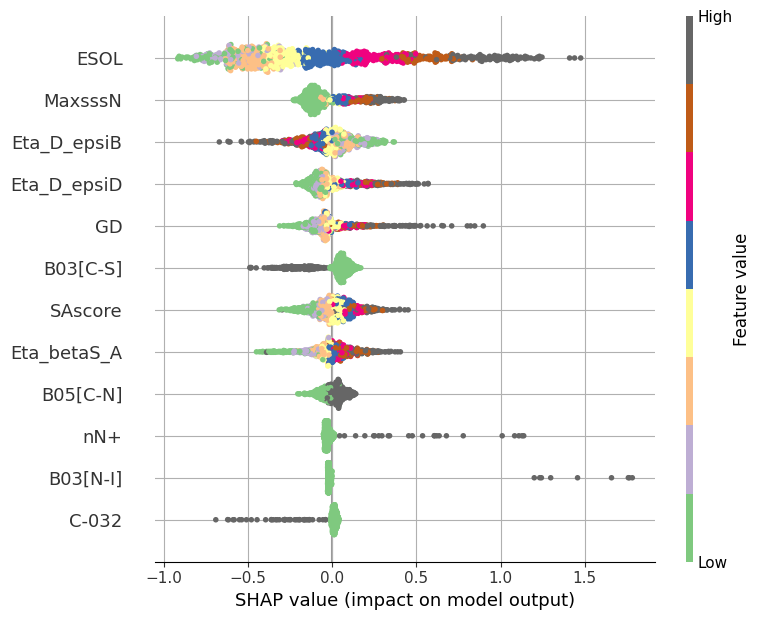

In [24]:
plt.grid()
shap.summary_plot(shap_an, x_tr, cmap=plt.get_cmap("Accent"))
plt.show()

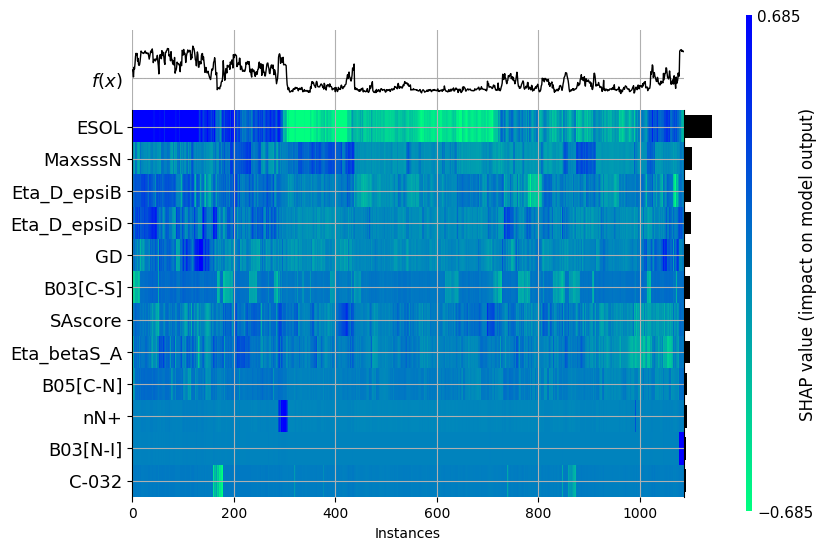

In [26]:
plt.grid()
shap.plots.heatmap(shap_an, cmap=plt.get_cmap("winter_r"), max_display=20)

In [29]:
index = input("Give index number:")
shap.plots.force(shap_an[int(index)])

Give index number: 0
